
# ECE795 Advanced Big Data Analytics Homework 4 (80 Points + 20 Bonus Points)

Set up Pyspark Environment.

Tips for Colab:

1. You will be disconnected if you are idle for more than 90 minutes and will be mandatorily disconnected after 12 hour connection. 

2. Once you got disconnected, you need to execute the codes from the beginning to setup the environment again.

3. For the purpose of homework, it should be sufficient since each problem should not take more than 5 minutes to generate the results.

4. To facilitate the use of Colab, you can use "MainMenu - Runtime - Run all” to run all the cells in the notebook. So you do not have to click each cell to setup the environment.

In [1]:
!pip install pyspark
!pip install -q findspark

import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

     |████████████████████████████████| 281.4 MB 34 kB/s 
     |████████████████████████████████| 198 kB 41.4 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=ccd3005d1dbbc888490c98882871835b6ca4c80f7bfa765e8a936811f94ca7a6
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


Congrats! Your Colab is ready to run Pyspark.

# Read input text file to RDD 

Download the input data from [here](https://raw.githubusercontent.com/umddm/ECE795_Homeworks/master/clust_B.txt).

In [2]:
!wget https://raw.githubusercontent.com/umddm/ECE795_Homeworks_Spring2022/homework_4/StudentsPerformance.csv

--2022-03-05 23:33:02--  https://raw.githubusercontent.com/umddm/ECE795_Homeworks_Spring2022/homework_4/StudentsPerformance.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 72036 (70K) [text/plain]
Saving to: ‘StudentsPerformance.csv’

StudentsPerformance 100%[===================>]  70.35K  --.-KB/s    in 0.01s   

2022-03-05 23:33:03 (5.81 MB/s) - ‘StudentsPerformance.csv’ saved [72036/72036]



Now that we have input data, we can start to do the homework. 

## Question 1: Please rewrite the given function only with the limited operation. (15 Points)

### Expected output:
```
.sum() by .map() and .reduce().

can be rewritten as .reduce(lambda a, b: a + b)
```

In [3]:
#sc.textFile
from pyspark import SparkConf, SparkContext
sc = SparkContext.getOrCreate()

#Sample
Sample = sc.textFile('StudentsPerformance.csv')
Sample = Sample.map(lambda x: x.replace('"', ''))
header = Sample.first()
Sample = Sample.filter(lambda line: line != header)
Sample.map(lambda x: int(x.split(',')[-1])).sum() == Sample.map(lambda x: int(x.split(',')[-1])).reduce(lambda a, b: a + b) 
#Output is Ture

True

### Question 1. 1: (5 Points)
Please implement .count() by .map() and .reduce().

In [4]:
Sample.count() == Sample.map(lambda word: 1).reduce(lambda a, b: a + b)

True

### Question 1. 2: (5 Points)
Please implement .stdev() by .map() and .reduce().

Round to the second decimal places

In [5]:
import numpy as np
mydata_Q_1_2 = Sample.map(lambda x: eval(x.split(',')[-1]))
rdd_count = mydata_Q_1_2.map(lambda x: 1).reduce(lambda a, b: a + b)    # .count()
rdd_mean = mydata_Q_1_2.reduce(lambda a, b: a + b) / rdd_count
# rdd_Q1_2.stdev() == np.sqrt(rdd_Q1_2.map(lambda x: (x - rdd_mean) ** 2).reduce(lambda a, b: a + b) / rdd_count)
round(mydata_Q_1_2.stdev(), 2) == round(np.sqrt(mydata_Q_1_2.map(lambda x: (x - rdd_mean) ** 2).reduce(lambda a, b: a + b) / rdd_count), 2)

True

### Question 1. 3: (5 Points)
Please implement .reduceByKey() by partitionBy(), map() and glom()

A hint to solve this problem is that a custom partitioner should be implemented and use glom to group the data.


In [88]:
mydata_Q_1_3 = sc.parallelize(['y','z','y','z','y','z','y','y'])
mydata_Q_1_3_count = mydata_Q_1_3.distinct().count()  # 2
print (mydata_Q_1_3.map(lambda x: (x, x)).partitionBy(mydata_Q_1_3_count, lambda x: hash(x)).map(lambda x: x[0]).glom().map(lambda word: (word[0], len(word))).collect())
print (mydata_Q_1_3.map(lambda word: (word, 1)).reduceByKey(lambda a, b: a + b).map(lambda x: (x[0], x[1])).collect())

[('y', 5), ('z', 3)]
[('y', 5), ('z', 3)]


In [89]:
mydata_Q_1_3.map(lambda word: (word, 1)).reduceByKey(lambda a, b: a + b).map(lambda x: (x[0], x[1])).collect() == mydata_Q_1_3.map(lambda x: (x, x)).partitionBy(mydata_Q_1_3_count, lambda x: hash(x)).map(lambda x: x[0]).glom().map(lambda word: (word[0], len(word))).collect()

True

## Question 2: Please create an RDD, which contains range(12) with 3 partitions. Then count the minimum of the partition 1, the maximum of the partition 2, and the sum of the third partition. (15 Points)


### Sample:
```
min of the partition 1 = 1
max of the partition 2 = 10
sum of the partition 3 = 20
```

In [9]:
mydata_Q_2 = sc.parallelize(range(12), 3)
def f(splitIndex, iterator):
  if splitIndex==0:
    yield min(iterator)
  elif splitIndex==1:
    yield max(iterator)
  else:
    yield sum(iterator)

result = mydata_Q_2.mapPartitionsWithIndex(f).glom().collect()
result_list = np.array(mydata_Q_2.mapPartitionsWithIndex(f).collect())
print ('min of the partition 1 = %d'% (result_list[0])) 
print ('max of the partition 2 = %d'% (result_list[1])) 
print ('sum of the partition 3 = %d'% (result_list[2])) 

min of the partition 1 = 0
max of the partition 2 = 7
sum of the partition 3 = 38


## Question 3: Why will pre-partition benefit spark job? Please write a short explanation and a code to prove your answer. (20 Points)

### Hint:
`ToDebugString()` can be used to debug. Detailed description can be found at https://spark.apache.org/docs/latest/api/java/org/apache/spark/rdd/RDD.html#toDebugString--

You can use `toDebugString()` like below:
```
rdd = sc.textFile('clust_B_part1.txt').toDebugString() 
```

yz_Solution:

**Pre**-Partitioning and Its Advantages:

---


Pre-partitioning means to create the partition using operation, e.g, , before transforming the data for data analysis.

Pre-partitioning is for the purpose of computation
efficiency

*   Shuffle is costly in computations and communications
*   Avoiding unnecessary shuffle is critical for efficient
processing

When an RDD is used for multiple operations that create
partitions and the same partitioner can be applied, we
should apply pre-partitioning.

In [87]:
import time
rdd = sc.parallelize(list(range(10000))).map(lambda x: (x % 10, x))

# Without pre-partition;
Start_1 = time.time()
rst1 = rdd.reduceByKey(lambda v1, v2: v1 + v2)   # First shuffle
rst2 = rdd.reduceByKey(lambda v1, v2: v1 * v2)  # Second shuffle
End_1 = time.time()
print('Total time without pre-partition: %f'%(End_1 - Start_1))

# With pre-partition;
Start_2 = time.time()
rdd_part = rdd.partitionBy(10).persist() # Shuffle only occurs here
rst1 = rdd_part.reduceByKey(lambda v1, v2: v1 + v2)  # No shuffle
rst2 = rdd_part.reduceByKey(lambda v1, v2: v1 * v2)  # No shuffle
End_2 = time.time()
print('Total time with pre-partition : %f'%(End_2 - Start_2))

# Pre-partitioning is for the purpose of computation efficiency.
# 1.Shuffle is costly in computations and communications
# 2.Avoiding unnecessary shuffle is critical for efficient processing
# When an RDD is used for multiple operations that create partitions and the same partitioner can be applied, we should apply pre-partitioning.

Total time without pre-partition: 0.035420
Total time with pre-partition : 0.018590


## Question 4: Please implement the K-Means algorithm described in the lecture slide. And test the implemented algorithm with data in "s1.txt" (k=15). (30 Points)


The coordinates of the center change less than 0.1 are considered as unchanged.

### Input data format:
Each row describe a point using two integers, which are its x and y coordinates.
The ID of the points is the row number, i.e., the point in the first row has ID=1, the point in the second row has ID=2, etc.

### Expected output format:
Each line describes a cluster including the cluster ID and the coordinate of its center
```
Cluster 1 (12.00, 67.33)
Cluster 2 (33.25, 23.02)
...
Cluster 15 (123.43, 456.30)
```

### Hint:
`zipWithIndex()` can be used to add index to the rdd. Detailed description can be found at https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.zipWithIndex

In [11]:
# Please download the data using the following commands
!wget http://cs.joensuu.fi/sipu/datasets/s1.txt

--2022-03-05 23:33:11--  http://cs.joensuu.fi/sipu/datasets/s1.txt
Resolving cs.joensuu.fi (cs.joensuu.fi)... 193.167.239.10
Connecting to cs.joensuu.fi (cs.joensuu.fi)|193.167.239.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 105000 (103K) [text/plain]
Saving to: ‘s1.txt’

s1.txt              100%[===================>] 102.54K   227KB/s    in 0.5s    

2022-03-05 23:33:12 (227 KB/s) - ‘s1.txt’ saved [105000/105000]



Cluster 1  (606574.96, 574455.17)
Cluster 2  (856684.76, 592627.10)
Cluster 3  (168840.83, 345737.02)
Cluster 4  (416754.89, 168273.36)
Cluster 5  (337264.76, 562123.38)
Cluster 6  (669176.09, 862820.66)
Cluster 7  (859341.61, 531362.26)
Cluster 8  (807347.47, 761740.06)
Cluster 9  (852058.45, 157685.52)
Cluster 10  (801336.54, 320450.00)
Cluster 11  (617870.07, 398983.26)
Cluster 12  (326800.24, 818471.65)
Cluster 13  (829943.24, 719680.20)
Cluster 14  (139395.23, 558143.94)
Cluster 15  (398870.05, 404924.07)


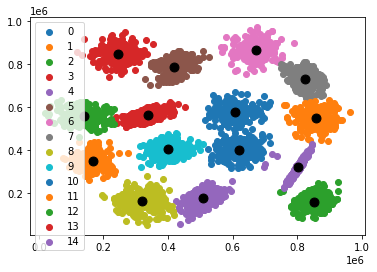

In [86]:
#Question_4
#Fill out here
import numpy as np

mydata_Q_4 = sc.textFile('s1.txt').map(lambda x: x.split('    ')).map(lambda x: np.array([int(x[1]), int(x[2])]))
center = np.array(mydata_Q_4.takeSample(False, 15, 0))
center_error = 1
k = 0

def Q_4_distance(x, center):
  distances = np.zeros(15)
  for i, c in enumerate(center):
    distances[i] = np.linalg.norm(x - c)
  return (np.argmin(distances) + 1)

while (center_error >= 0.1):
  mydata_Q_4_distance = mydata_Q_4.map(lambda x: (Q_4_distance(x, center), np.array([x[0], x[1]])))
  update_center = np.array(mydata_Q_4_distance.aggregateByKey((0, 0), lambda x, y: (x[0] + y, x[1] + 1), lambda x, y: (x[0] + y[0], x[1] + y[1]))\
  .mapValues(lambda x: x[0] / x[1])\
  .sortBy(lambda x: x[0]).values().collect())
  center_error = np.sum(np.abs(center - update_center))
  center = update_center
  k += 1
  # print(k, center_error)

for i, c in enumerate(update_center):
  print('Cluster %d  (%.2f, %.2f)'%(i + 1, c[0], c[1]))

#plot
import matplotlib.pyplot as plt
mydata_Q_4_list = np.array(mydata_Q_4.map(lambda x: (x[0], x[1])).collect())
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters= 15)
label = kmeans.fit_predict(mydata_Q_4_list)
u_labels = np.unique(label)
centroids = kmeans.cluster_centers_
u_labels = np.unique(label)
for i in u_labels:
    plt.scatter(mydata_Q_4_list[label == i , 0] , mydata_Q_4_list[label == i , 1] , label = i)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
plt.legend()
plt.show()

## Question 5: Please implement the One-Dimension Gaussian Mixture model described in the following. And test the implemented algorithm with the **first column** of data in "s1.txt" (k = 15). (Bonus: 20 Points)


No matter whether the model converges, run the model for 10 iterations

### Algorithm Description

This algorithm is similar to K-Means, clustering the given data. Different from K-means, Gaussain Mixture model defines each cluster by mean, variance and weight, instead of the coordination of the cluster center

- Step1: Assign initial means, variance, and weights of each cluster

  - Each cluster is defined by three value $C(\mu, \sigma^2, w)$. 
  - Mean $\mu$ can be initialized by the value of a randomly selected data. 
  - Variance $\sigma^2$ can be initialized by the variance of 15 randomly selected data. 
  - Weight $w$ can be initialized by 1.

- Step2: Go to an iteration

  - Compute a score for each data point $x$ and all the clusters, using the provided *pdf* function.
  - Assign each data point to the cluster with the highest score
  - Compute normalized score of each data point by: $S_{i,k}=\dfrac{s_{i,k}}{\sum_{j=1}^{K}{s_{i,j}}}$ ($K$ is the number of clusters)
  - For each cluster k 
    - Update mean of the cluster by: $\mu_k'=\dfrac{\sum_{i=1}^{N}(x_iS_{i,k})}{0.001+\sum_{i=1}^{N}{S_{i,k}}}$
    - Update variance of the cluster by: $\sigma_k'^2 = \dfrac{\sum_{i=1}^{N}[S_{i,k}(x_i - \mu)^2]}{0.001+\sum_{i=1}^{N}{S_{i,k}}}$
    - Update weight of the cluster by: $\dfrac{\sum_{i=1}^{N}S_{i,k}}{N}$
    - $N$ is the number of data points in the dataset
    - $s_{i,k}$ is the score of the $i$-th data point for the cluster k

### Expected output format:
Each line describes a cluster including the cluster ID, mean, variance, and weight.
```
Cluster 1: mean=12.00, variance=1.23, weight=2.23
Cluster 2: mean=5.23, variance=2.33, weight=4.23
...
Cluster 15: mean=17.20, variance=0.64, weight=1.68
```

In [13]:
def pdf(data: float, mean: float, variance: float, weight: float):
  s1 = 1/(np.sqrt(2*np.pi*variance))
  s2 = np.exp(-(np.square(data - mean)/(2*variance)))
  return s1 * s2 * weight

In [84]:
#Question_5
#Fill out here

import numpy as np

mydata_Q_5 = sc.textFile('s1.txt').map(lambda x: x.split('    ')).map(lambda x: int(x[1]))
means = mydata_Q_5.takeSample(False, 15)
variances = []
weights = [1] * 15

def pdf(data: float, mean: float, variance: float, weight: float):
  s1 = 1/(np.sqrt(2*np.pi*variance))
  s2 = np.exp(-(np.square(data - mean)/(2*variance)))
  return s1 * s2 * weight

def pdfs(data, means, variances, weights):
  values = []
  for i in range(15):
    values.append(pdf(data, means[i], variances[i], weights[i]))
  Cluster_argmax = np.argmax(values)
  return (data, Cluster_argmax, max(values))

def norm(sum, values):
  return values/(0.001 + sum)

for i in range(15):
  variances.append(np.var(mydata_Q_5.takeSample(False, 15)))

for _ in range(10):
    mydata_Cluster_ID_values = mydata_Q_5.map(lambda data: pdfs(data, means, variances, weights))
    Cluster_ID_values = mydata_Cluster_ID_values.map(lambda x: (x[1], x[2]))
    Cluster_sum = Cluster_ID_values.reduceByKey(lambda v1, v2: v1 + v2)
    Cluster_ID_values_norm = Cluster_sum.join(mydata_Cluster_ID_values.map(lambda x: (x[1], (x[0], x[2])))).map(lambda x: (x[0], (x[1][1][0], norm(x[1][0], x[1][1][1]))))
    Cluster_ID_mean_1 = Cluster_ID_values_norm.mapValues(lambda x: x[0] * x[1]).reduceByKey(lambda v1, v2: v1 + v2)
    Cluster_ID_mean_2 = Cluster_ID_values_norm.mapValues(lambda x: x[1]).reduceByKey(lambda v1, v2: v1 + v2)
    Cluster_ID_mean = Cluster_ID_mean_1.join(Cluster_ID_mean_2).mapValues(lambda x: x[0]/(0.001 + x[1])).collect()
    for (Cluster_ID, update_mean) in Cluster_ID_mean:
      means[Cluster_ID] = update_mean

    Cluster_ID_var_1 = Cluster_ID_values_norm.map(lambda x: (x[0], x[1][1] * (x[1][0] - means[x[0]])**2)).reduceByKey(lambda v1, v2: v1 + v2)
    Cluster_ID_var = Cluster_ID_var_1.join(Cluster_ID_mean_2).mapValues(lambda x: x[0]/(0.001 + x[1])).collect()
    for (Cluster_ID, update_var) in Cluster_ID_var:
      variances[Cluster_ID] = update_var

    Cluster_ID_weight = Cluster_ID_mean_2.mapValues(lambda x: x / 15).collect()
    for (Cluster_ID, update_weight) in Cluster_ID_weight:
      weights[Cluster_ID] = update_weight

for i in range(15):
  print('Cluster %d:  mean=%.2f,  variance=%.2f,  weight=%f'%(i + 1, means[i], variances[i], weights[i]))

Cluster 1:  mean=18999.83,  variance=3221886401.53,  weight=0.000007
Cluster 2:  mean=260340.71,  variance=32445870898.79,  weight=0.000070
Cluster 3:  mean=138.54,  variance=7889750.18,  weight=0.000000
Cluster 4:  mean=45235.90,  variance=22401357479.70,  weight=0.000006
Cluster 5:  mean=27156.15,  variance=12328290665.66,  weight=0.000004
Cluster 6:  mean=1321.79,  variance=109393398.49,  weight=0.000001
Cluster 7:  mean=73.24,  variance=69083802.60,  weight=0.000000
Cluster 8:  mean=711023.05,  variance=6957708594.74,  weight=0.000558
Cluster 9:  mean=6908.69,  variance=1314542490.90,  weight=0.000002
Cluster 10:  mean=383.83,  variance=230555134.08,  weight=0.000000
Cluster 11:  mean=205176.87,  variance=12371813659.93,  weight=0.000098
Cluster 12:  mean=5.00,  variance=133729.68,  weight=0.000000
Cluster 13:  mean=126903.70,  variance=6411757174.53,  weight=0.000083
Cluster 14:  mean=96039.50,  variance=29717203734.33,  weight=0.000017
Cluster 15:  mean=34528.75,  variance=225898